In [51]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
from utils import checkpoint, warning
from utils import effective_sample_size
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import visualization as vis
import importlib
import pandas as pd
np.random.seed(0)

In [52]:
# questo serve altrimenti non usa l'ultima versione dei file .py
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(vis);

# Information Theory Project

Cose da **fare**:
- Ottenere risultati finali
- Sistemare codice
- Sistemare i plot
- Slide

## Microcanonical Hamiltonian Montecarlo

---- 
### Bimodal distribution
#### a.1) Parameters optimization - LF

In [3]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f2fdac2d2d0> with 200 steps, updating epsilon


Running iterations:   0%|                                                                                                             | 0/5 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Running iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.17s/it]

Optimal epsilon: 6.215548801422119


In [4]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d,int_scheme=integ.leapfrog, N=N, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f2fdac2d2d0> with 200 steps, updating L


Running iterations:   0%|                                                                                                             | 0/5 [00:00<?, ?it/s]E0624 14:20:45.282416  196323 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.5.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0624 14:20:45.283023  196323 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.5.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
Running iterations: 100%|███████████████████

Optimal L: 11.209916877746583


#### b.1) Finding ESS - LF

Compute $b_2^2=\frac{2}{n_{eff}}$ and $ESS=\frac{200}{n}$ with n number of gradient density evaluations needed to reach $b_2 = 0.1$.

- First strategy:

  $n_{eff}^{(i)}$ is obtained via blackjax over each dimension, and $n_{eff}=\sum_{i}n_{eff}^{(i)}/d$.

- Second strategy:

    Same as the first, just $n_{eff}=min(n_{eff}^{(i)})$

In [10]:
n_chains = 5
X = []
ESS_mean = []
ESS_min = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, pbar=True)
    utils.check_two_modes(Xi, no_print=True)
    X.append(Xi[500:,:]) # burn-in
    ess_mean = utils.find_ess(Xi, take_minimum=False)
    ess_min = utils.find_ess(Xi, take_minimum=True)
    ESS_mean.append(ess_mean)
    ESS_min.append(ess_min)

X = torch.cat(X, dim=0)
two_modes = utils.check_two_modes(X, no_print=True)
if not two_modes: print("mierdas, single mode")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 98.95it/s]


In [12]:
print(f'ESS for bimodal distribution with MCHMC-bounces with LP integrator \n mean: {np.mean(ESS_mean[ESS_mean != None]):.3f} \n min: {np.mean(ESS_min[ESS_min != None]):.3f}')

ESS for bimodal distribution with MCHMC-bounces with LP integrator 
 mean: 0.052 
 min: 0.039


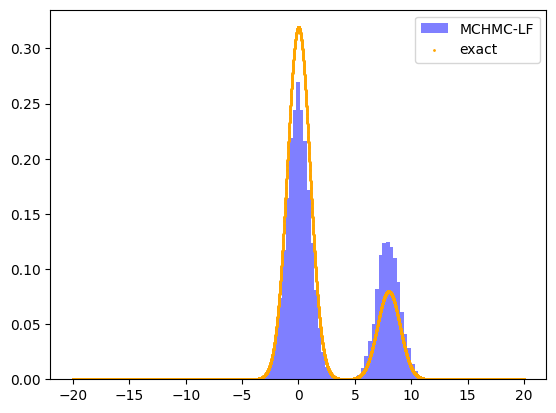

In [18]:
from scipy.stats import norm 
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

#X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

- Third strategy:

  Using ground truth momentum

In [35]:
n_chains = 10
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, pbar=True)
    utils.check_two_modes(Xi, no_print=False)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.ESS_bimodal(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)
two_modes = utils.check_two_modes(X, no_print=False)
if not two_modes: print("mierdas, single mode")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 100.94it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 100.49it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 100.01it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 101.24it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 101.12it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 101.32it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 100.53it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 100.92it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 100.23it/s]


(Probably) TWO mode sampled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 100.37it/s]


(Probably) TWO mode sampled
(Probably) TWO mode sampled


In [36]:
ESS_valid = ESS[ESS != None]
if ESS_valid is not None: print("ESS for bimodal distribution with MCHMC-bounces with LP integrator \n truth", np.mean(ESS_valid))
ESS

ESS for bimodal distribution with MCHMC-bounces with LP integrator 
 truth 0.0392156862745098


[0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 0.0392156862745098,
 None,
 None,
 0.0392156862745098]

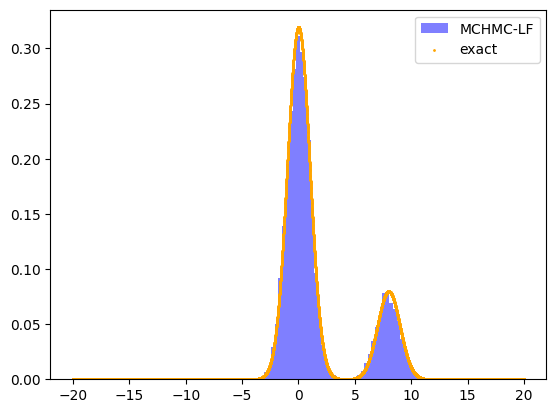

In [37]:
from scipy.stats import norm 
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

#### a.2) Parameters optimization - MN

In [19]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.minimal_norm, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f696c998af0> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.08s/it]


Optimal epsilon: 14.372690391540527


In [20]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.minimal_norm, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f696c998af0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.18s/it]

Optimal L: 7.755443668365478


#### b.2) Finding ESS - MN

In [21]:
n_chains = 5
X = []
ESS_mean = []
ESS_min = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, int_scheme=integ.minimal_norm, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess_mean = utils.find_ess(Xi, take_minimum=False)
    ess_min = utils.find_ess(Xi, take_minimum=True)
    ESS_mean.append(ess_mean)
    ESS_min.append(ess_min)

X = torch.cat(X, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:32<00:00, 53.85it/s]


In [24]:
print(f'ESS for bimodal distribution with MCHMC-bounces with MN integrator \n mean: {np.mean(ESS_mean[ESS_mean!=None]):.3f} \n min: {np.mean(ESS_min[ESS_min!=None]):.3f}')

ESS for bimodal distribution with MCHMC-bounces with MN integrator 
 mean: 0.397 
 min: 0.247


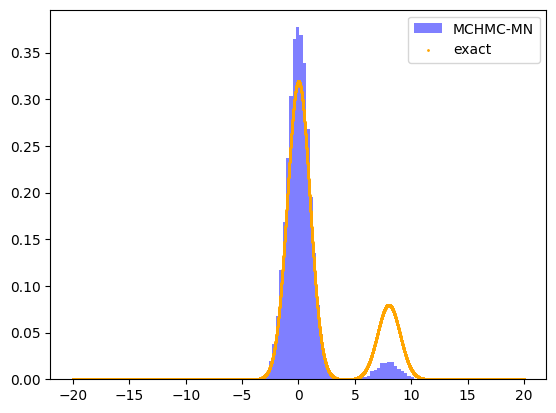

In [25]:
from scipy.stats import norm 
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-MN')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

---------------

### Ill conditioned Gaussian distribution

#### a.1) Parameters optimization - LF

In [53]:
# get the covariance matrix of the distribution 
d = 100
cov = funct.get_ill_cov(d)

In [54]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=5, fn=funct.ill_cond_gaussian,
                                         algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, 
                                         iterations=5, debug=False, cov=cov)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f2cdc5f3370> with 200 steps, updating epsilon


Running iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]

Optimal epsilon: 1.4283899784088134


In [55]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.ill_cond_gaussian,
                      algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5, cov=cov)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f2cdc5f3370> with 200 steps, updating L


Running iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]

Optimal L: 13.057251739501954


#### b.1) Finding ESS - LF

In [103]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.ill_cond_gaussian, int_scheme=integ.leapfrog, pbar=True, cov=cov)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 176.17it/s]


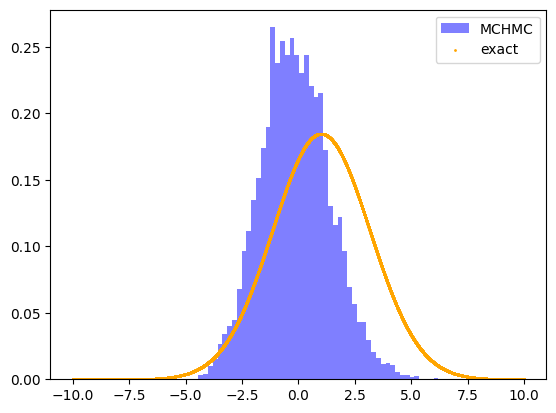

In [109]:
from scipy.stats import norm 
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 1, cov[0,0]) 

#X = X.detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

#### a.2) Parameters optimization - MN

In [111]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=10, fn=funct.ill_cond_gaussian, algorithm=MCHMC.MCHMC_bounces, 
                                         int_scheme=integ.minimal_norm, iterations=5, debug=False, cov=cov)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]

Optimal epsilon: 5.346311807632446


In [114]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.ill_cond_gaussian,
                      algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.minimal_norm, iterations=5, cov=cov)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]

Optimal L: 20.087843260654303


#### b.2) Finding ESS - MN

In [115]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.ill_cond_gaussian, int_scheme=integ.minimal_norm, pbar=True, cov=cov)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 127.16it/s]


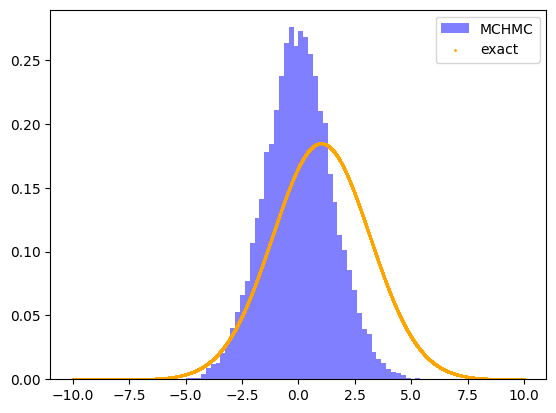

In [116]:
from scipy.stats import norm 
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 1, cov[0,0]) 

X = X.detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

b.3)

In [63]:
n_chains = 5
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.ill_cond_gaussian, pbar=True, cov=cov)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.ESS_gaussian(Xi,cov)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 172.96it/s]


In [64]:
ESS_valid = ESS[ESS != None]
if ESS_valid is not None: print("ESS for bimodal distribution with MCHMC-bounces with LP integrator \n truth", np.mean(ESS_valid))
ESS

ESS for bimodal distribution with MCHMC-bounces with LP integrator 
 truth 0.0227842333105491


[0.026483050847457626,
 0.0227842333105491,
 0.026483050847457626,
 0.021299254526091587,
 0.0227842333105491]

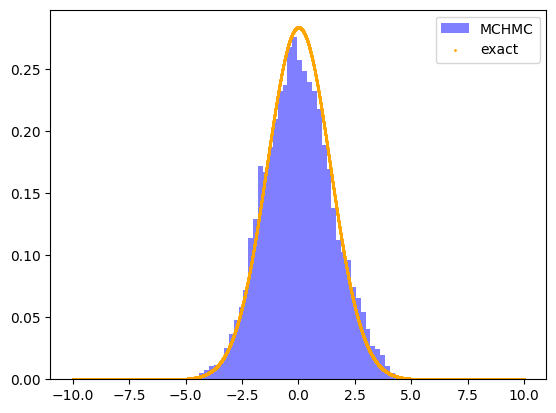

In [65]:
from scipy.stats import norm 
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 0, np.sqrt(cov[0,0])) 

#X = X.detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

---------------

### Rosenbrock - Parameters optimization 

- *Leapfrog integrator*:

In [118]:
d = 36
N = 500
eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=np.sqrt(d), fn=funct.rosenbrock,
                                         algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]

Optimal epsilon: 0.1651273250579834


In [119]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.rosenbrock, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]

Optimal L: 4.61011203142389


In [120]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=d, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.rosenbrock, int_scheme=integ.leapfrog, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 210.78it/s]


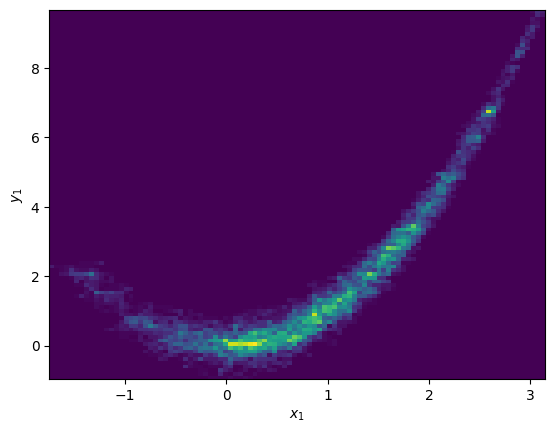

In [121]:
plt.hist2d(X[:, 0], X[:, 1], 100)
plt.xlabel(fr'$x_1$')
plt.ylabel(fr'$y_1$')
plt.show()

- *Minimal Norm integrator*:

---------------

### Neal's funnel - Parameters optimization

- *Leapfrog integrator*:

In [122]:
d = 20
N = 500
eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=np.sqrt(d), fn=funct.neals_funnel,
                                         algorithm=MCHMC.MCHMC_bounces, iterations=5, int_scheme=integ.leapfrog, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]

Optimal epsilon: 0.7082988619804382


In [123]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.neals_funnel, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.92s/it]

Optimal L: 11.091380052307914


In [124]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=d, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.neals_funnel, int_scheme=integ.leapfrog, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 197.90it/s]


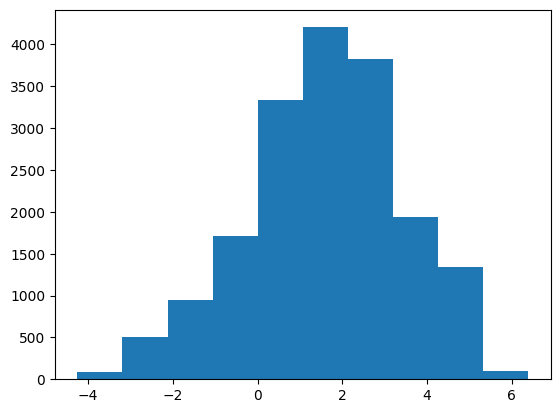

In [125]:
plt.hist(X[:,0])
plt.show()

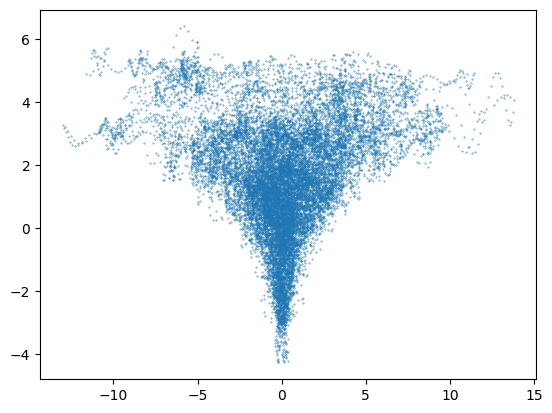

In [127]:
plt.scatter(X[:, 1], X[:, 0], s=0.1)
plt.show()

- *Minimal Norm integrator*:

## Langevin-like Hamiltonian Montecarlo
--- 

### Bimodal distribution 
#### a.1) Parameters optimization - LF

In [26]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs, _ = aut.tune_eps(d=100, N=200, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, int_scheme=integ.leapfrog, iterations=5)

sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCLMC at 0x7f696c99a050> with 200 steps, updating epsilon


Running iterations:   0%|                                                                                      | 0/5 [00:00<?, ?it/s]/home/ubuntu/MCHMC/MCLMC.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=device)
Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


Optimal epsilon: 6.3171131134033205


In [29]:
eps_opt = torch.tensor(eps_opt, device=utils.choose_device())
L_values = aut.tune_L(sigma_eff, eps_opt, d=100, N=200, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, int_scheme=integ.leapfrog, debug=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')

/tmp/ipykernel_154561/3862564447.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eps_opt = torch.tensor(eps_opt, device=utils.choose_device())



Running 5 iterations of <function MCLMC at 0x7f696c998af0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]

Optimal L: 8.711718615293842


#### b.1) Finding ESS - LF

In [30]:
n_chains = 5
X = []
ESS_mean = []
ESS_min = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCLMC.MCLMC(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess_mean = utils.find_ess(Xi, take_minimum=False)
    ess_min = utils.find_ess(Xi, take_minimum=True)
    ESS_mean.append(ess_mean)
    ESS_min.append(ess_min)

X = torch.cat(X, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 85.57it/s]


In [32]:
print(f'ESS for bimodal distribution with MCLMC with LP integrator \n mean: {np.mean(ESS_mean):.3f} \n min: {np.mean(ESS_min):.3f}')

ESS for bimodal distribution with MCLMC with LP integrator 
 mean: 0.141 
 min: 0.098


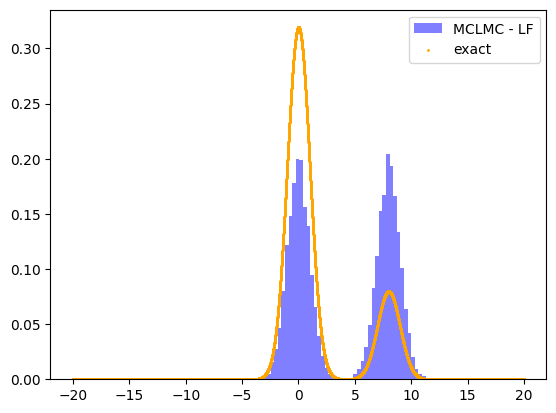

In [34]:
from scipy.stats import norm 
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

#X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC - LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

#### a.2) Parameters optimization - MN

In [35]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs, _ = aut.tune_eps(d=100, N=200, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, int_scheme=integ.minimal_norm, iterations=5)

sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCLMC at 0x7f696c998af0> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.14s/it]


Optimal epsilon: 14.138198471069336


In [36]:
eps_opt = torch.tensor(eps_opt, device=utils.choose_device())
L_values = aut.tune_L(sigma_eff, eps_opt, d=100, N=200, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, int_scheme=integ.minimal_norm, debug=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCLMC at 0x7f696c998af0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.31s/it]

Optimal L: 7.358254586867881


#### b.2) Finding ESS - MN

In [38]:
n_chains = 5
X = []
ESS_mean = []
ESS_min = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCLMC.MCLMC(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, int_scheme=integ.minimal_norm, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess_mean = utils.find_ess(Xi, take_minimum=False)
    ess_min = utils.find_ess(Xi, take_minimum=True)
    ESS_mean.append(ess_mean)
    ESS_min.append(ess_min)

X = torch.cat(X, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:19<00:00, 62.70it/s]


In [41]:
print(f'ESS for bimodal distribution with MCLMC with MN integrator \n mean: {np.mean(ESS_mean[ESS_mean!=None]):.3f} \n min: {np.mean(ESS_min[ESS_min!=None]):.3f}')

ESS for bimodal distribution with MCLMC with MN integrator 
 mean: 0.397 
 min: 0.305


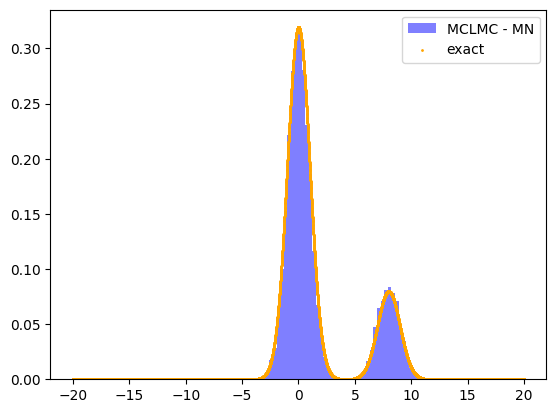

In [42]:
from scipy.stats import norm 
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC - MN')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

------------

### Ill conditioned Gaussian distribution - Parameters optimization

- *Leapfrog integrator*:

In [145]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=torch.tensor(5), fn=funct.ill_cond_gaussian, algorithm=MCLMC.MCLMC, int_scheme=integ.leapfrog, iterations=5, debug=False, cov=cov)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCLMC at 0x7f595c3d4670> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


Optimal epsilon: 1.351828360557556


In [146]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.ill_cond_gaussian, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5, cov=cov)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]

Optimal L: 12.246573077622449


In [148]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCLMC.MCLMC(d=100, N=5000, L=torch.tensor(L_opt), epsilon=torch.tensor(eps_opt), fn=funct.ill_cond_gaussian, int_scheme=integ.leapfrog, pbar=True, cov=cov)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi, grad_evaluations=3)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 154.84it/s]


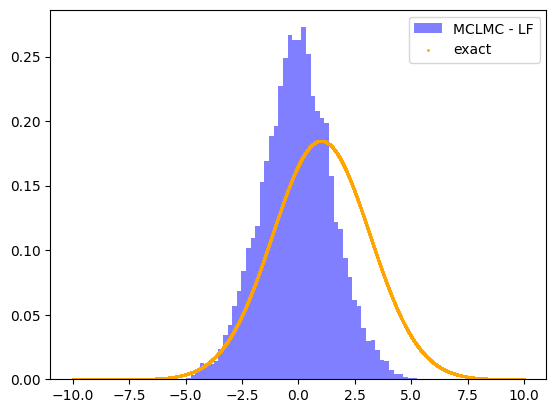

In [151]:
from scipy.stats import norm 
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 1, cov[0,0]) 

#X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC - LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.show()

- *Minimal Norm integrator*:

---------------

### Rosenbrock - Parameters optimization 

- *Leapfrog integrator*:

In [154]:
d = 36
N = 500
eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=torch.tensor(np.sqrt(d)), fn=funct.rosenbrock,
                                         algorithm=MCLMC.MCLMC, int_scheme=integ.leapfrog, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCLMC at 0x7f595c3d4670> with 500 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]

Optimal epsilon: 0.14719914942979812


In [155]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, torch.tensor(eps_opt), d, N=N, fn=funct.rosenbrock, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.79s/it]

Optimal L: 5.660648748396957


In [157]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCLMC.MCLMC(d=d, N=5000, L=torch.tensor(L_opt), epsilon=torch.tensor(eps_opt), fn=funct.rosenbrock, int_scheme=integ.leapfrog, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 205.57it/s]


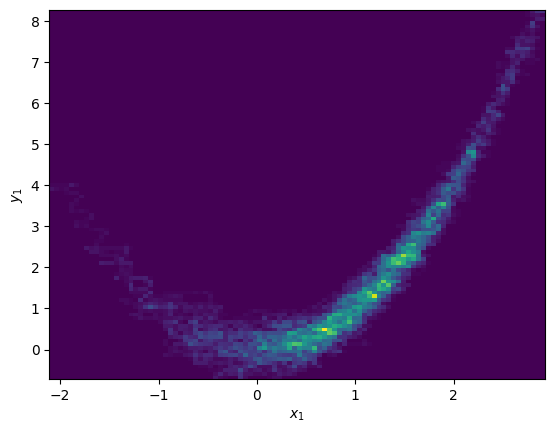

In [158]:
plt.hist2d(X[:, 0], X[:, 1], 100)
plt.xlabel(fr'$x_1$')
plt.ylabel(fr'$y_1$')
plt.show()

- *Minimal Norm integrator*:

---------------

### Neal's funnel - Parameters optimization

- *Leapfrog integrator*:

In [160]:
d = 20
N = 500
eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=torch.tensor(np.sqrt(d)), fn=funct.neals_funnel,
                                         algorithm=MCLMC.MCLMC, iterations=5, int_scheme=integ.leapfrog, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCLMC at 0x7f595c3d4670> with 500 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]

Optimal epsilon: 0.7080623924732208


In [161]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.neals_funnel, algorithm=MCHMC.MCHMC_bounces, int_scheme=integ.leapfrog, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7f5906e088b0> with 500 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.73s/it]

Optimal L: 16.626697796244144


In [162]:
n_chains = 4
X = []
ESS = []
pbar = False
bar = range(n_chains)
if pbar:
    bar = tqdm(bar)
for i in bar:
    Xi, *_ = MCHMC.MCHMC_bounces(d=d, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.neals_funnel, int_scheme=integ.leapfrog, pbar=True)
    X.append(Xi[500:,:]) # burn-in
    ess = utils.find_ess(Xi)
    ESS.append(ess)

X = torch.cat(X, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 223.34it/s]


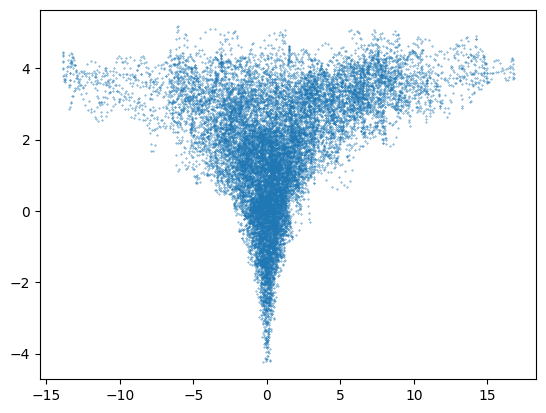

In [163]:
plt.scatter(X[:, 1], X[:, 0], s=0.1)
plt.show()

- *Minimal Norm integrator*: